<a href="https://colab.research.google.com/github/inoueshinichi/Book_Image_Recognition/blob/main/ch04_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformerエンコーダ構造

## インポート

In [ ]:
from collections import deque
import copy
from tqdm import tqdm

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as T

## Google Drive マウント

In [ ]:
# Googleドライブをマウント
# from google.colab import drive
# drive.mount('/content/drive')

## マルチヘッドテンションを使った自己アテンションの実装

In [ ]:
class SelfAttention(nn.Module):
  '''自己アテンション
  dim_hidden: 入力特徴量の次元
  num_heads : マルチヘッドアテンションのヘッド数
  qkv_bias  : クエリなどを生成する全結合層のバイアスの有無
  '''
  def __init__(self,
               dim_hidden: int,
               num_heads: int,
               qkv_bias: bool=False):
    super().__init__()

    # 特徴量を各ヘッドのために分割するので、
    # 特徴量次元をヘッド数で割り切れるか検証
    assert dim_hidden % num_heads == 0

    self.num_heads = num_heads

    # ヘッド毎の特徴量次元
    dim_head = dim_hidden // num_heads

    # ソフトマックスのスケール値
    self.scale = dim_head ** -0.5

    # ヘッド毎にクエリ、キー、バリューを生成するための全結合層
    self.proj_in = nn.Linear(dim_hidden, dim_hidden * 3, bias=qkv_bias)

    # 各ヘッドから得られた特徴量を一つにまとめる全結合層
    self.proj_out = nn.Linear(dim_hidden, dim_hidden)


  '''
  順伝搬関数
  x: 入力特徴量, [バッチサイズ, 特徴量数, 特徴量次元]
  '''
  def forward(self, x: torch.Tensor):
    bs, ns = x.shape[:2]
    # 特徴量数は, 例えば, 画像の1ピクセル=特徴量とするならば, ピクセル数の数.
    # セルで区切ってパッチ化するならばパッチ数

    qkv = self.proj_in(x)

    # view関数により (多次元配列のコピーを作らず参照を組み替える)
    # [バッチサイズ, 特徴量数, QKV, ヘッド数, ヘッドの特徴量次元]
    # permute関数により
    # [QKV, バッチサイズ, ヘッド数, 特徴量数, ヘッドの特徴量次元]
    qkv = qkv.view(bs, ns, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4) # コピー発生

    # (Q,K,V)に分解
    q,k,v = qkv.unbind(0) # [バッチサイズ, ヘッド数, 特徴量数, ヘッドの特徴量次元]

    # クエリとキーの行列積とアテンションの計算(今回マスクは不使用)
    # attnは, [バッチサイズ, ヘッド数, 特徴量数(Nq), 特徴量数(Nkv)]
    # [バッチサイズ, ヘッド数, 特徴量数, ヘッドの特徴量次元] * [バッチサイズ, ヘッド数, ヘッドの特徴量次元, 特徴量数]
    attn = q.matmul(k.transpose(-2, -1)) # [バッチサイズ(bs), ヘッド数(h), 特徴量数(N), 特徴量数(N)] N = Nq = Nkv
    attn = (attn * self.scale).softmax(dim=-1) # 列方向にソフトマックス

    # アテンションとバリューの行列積によりバリューを収集
    # xは, [バッチサイズ(bs), ヘッド数(h), 特徴量数(N), ヘッドの特徴量次元(ns)]
    x = attn.matmul(v) # [bs, h, N, ns] @ [bs, h, ns, N] = [bs, h, N, N]

    # permute関数により
    # [bs, N, h, ns]
    # flatten関数によりすべてのヘッドから得られる特徴量を連結して
    # [bs, N, h*ns]
    x = x.permute(0, 2, 1, 3).flatten(2)
    x = self.proj_out(x)

    return x

## GELU活性化関数を用いた全結合層
+ 活性化関数に入力する直前の中間の特徴量次元は, 大きい方がよい.
+ 活性化関数の非線形性によって特徴量次元が低いと特徴量が崩れてしまう恐れがある.


In [ ]:
class FNN(nn.Module):
  '''
  Transformerエンコーダ内の順伝播型ニューラルネットワーク
  dim_hidden : 入力特徴量の次元
  dim_feedforward : 中間特徴量の次元
  '''
  def __init__(self,
               dim_hidden: int,
               dim_feedforward: int):
    super().__init__()

    self.linear1 = nn.Linear(dim_hidden, dim_feedforward)
    self.linear2 = nn.Linear(dim_feedforward, dim_hidden)
    self.activation = nn.GELU()

  '''
  順伝播関数
  x: 入力特徴量 [バッチサイズ(bs), 特徴量数(ns), 特徴量次元]
  '''
  def forward(self, x: torch.Tensor):
    x = self.linear1(x)
    x = self.activation(x)
    x = self.linear2(x)

    return x

## Transformerエンコーダ層

In [ ]:
class TransformerEncoderLayer(nn.Module):
  '''
  Transformerエンコーダ層
  dim_hidden: 入力特徴量の次元
  num_heads: ヘッド数
  dim_feedforward: 中間特徴量の次元
  '''
  def __init__(self, dim_hidden: int,
               num_heads: int,
               dim_feedforward: int,
               ):
    super().__init__()

    # MHSA
    self.attention = SelfAttention(dim_hidden, num_heads)
    # FNN
    self.fnn = FNN(dim_hidden, dim_feedforward)

    self.norm1 = nn.LayerNorm(dim_hidden)
    self.norm2 = nn.LayerNorm(dim_hidden)

  '''
  順伝播関数
  x: 入力特徴量 [バッチサイズ(bs), 特徴量数(ns), 特徴量次元(d)]
  '''
  def forward(self, x: torch.Tensor):
    x = self.norm1(x)
    x = self.attention(x) + x
    x = self.norm2(x)
    x = self.fnn(x) + x
    return x

## Vision Transformerの実装

In [ ]:
class VisionTransformer(nn.Module):
  '''
  Vision Transformer
  num_classes: 分類対象の物体クラス数
  img_size: 入力画像の大きさ(幅と高さが等しいことを想定)
  patch_size: パッチの大きさ(幅と高さが等しいことを想定)
  dim_hidden: 入力特徴量の次元
  num_heads: マルチヘッドアテンションのヘッド数
  dim_feedforward: FNNにおける中間特徴量の次元(非線形活性化関数による特徴量の崩壊を防ぐ)
  num_layers: Transformerエンコーダの層数
  '''
  def __init__(self,
               num_classes: int,
               img_size: int,
               patch_size: int,
               dim_hidden: int,
               num_heads: int,
               dim_feedforward: int,
               num_layers: int,
               ):
    super().__init__()

    # 画像をパッチに分解するために
    # 画像の大きさがパッチの大きさで割り切れるか確認
    assert img_size % patch_size == 0

    self.img_size = img_size
    self.patch_size = patch_size

    # パッチの行数と列数は共にimg_size // patch_sizeであり,
    # パッチ数はその2乗となる
    num_patches = (img_size // patch_size) ** 2

    # パッチ特徴量はパッチを平坦化することにより生成されるため
    # その次元はpatch_size * patch_size * 3 (RGB)
    dim_patch = 3 * patch_size ** 2

    # パッチ特徴量をTransformerエンコーダに入力する前に
    # パッチ特徴量の次元を変換するための全結合層(Embedding)
    # nn.Conv2d(3, D, kernel=patch_size, stride=patch_size)で一気に計算できる
    self.patch_embed = nn.Linear(dim_patch, dim_hidden)

    # 位置埋め込み(パッチ数 + クラス埋め込みの分を用意) ※バッチ次元ですべて同じパラメータを使う?
    self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, dim_hidden))

    # クラス埋め込み
    self.class_token = nn.Parameter(torch.zeros(1, 1, dim_hidden))

    # Transformerエンコーダ層
    self.layers = nn.ModuleList([TransformerEncoderLayer(
        dim_hidden, num_heads, dim_feedforward
    ) for _ in range(num_layers)])

    # ロジットを生成する前のレイヤー正規化と全結合層
    self.norm = nn.LayerNorm(dim_hidden)
    self.linear = nn.Linear(dim_hidden, num_classes)

  '''
  順伝播関数
  x: 入力 [バッチ数(bs), 入力チャネル(C=3), 高さ(H), 幅(W)]
  '''
  def forward(self,
              x: torch.Tensor,
              return_embed: bool=False,
              ):
    bs, c, h, w = x.shape

    # 入力画像の大きさがクラス生成時に指定したimg_sizeと合致しているか確認
    assert h == self.img_size and w == self.img_size

    # 高さ軸と幅軸をそれぞれパッチ数 * パッチの大きさに分解し、
    # [バッチサイズ, チェネル数, バッチの行数, バッチの大きさ]
    # の形にする
    # (B,C,H,W) -> (B,C,PH,DH,PW,DW)
    x = x.view(bs, c,
               h // self.patch_size, self.patch_size,
               w // self.patch_size, self.patch_size)

    # (B,C,PH,DH,PW,DW) -> (B,PH,PW,C,HD,WD)
    x = x.permute(0, 2, 4, 1, 3, 5)

    # パッチの平坦化
    # permutate関数はメモリ配列を変更するので,
    # 後続でview関数を使えない
    x = x.reshape(bs, (h // self.patch_size) * (w // self.patch_size), -1)

    # 埋め込みベクトル
    x = self.patch_embed(x)

    # クラス埋め込みをバッチサイズ分用意
    class_token = self.class_token.expand(bs, -1, -1)

    x = torch.cat((class_token, x), dim=1)

    # クラス埋め込みに勾配が行くようにする
    x += self.pos_embed

    # Transformerのエンコーダ層を実行
    for layer in self.layers:
      x = layer(x)

    # クラス埋め込みをベースとした特徴量の抽出
    x = x[:, 0] # (bs, 1)

    x = self.norm(x)

    if return_embed:
      return x

    x = self.linear(x)

    return x

  '''
  モデルパラメータが保持されているデバイスを返す関数
  '''
  def get_device(self):
      return self.linear.weight.device

  '''
  モデルを複製して返す関数
  '''
  def copy(self):
      return copy.deepcopy(self)

# 学習・評価の準備

In [ ]:
import random
from collections import deque
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## CIFER-10データセット

In [ ]:
cifer10_check_dataset = torchvision.datasets.CIFAR10(
    root='data', train=True, download=True, transform=T.ToTensor()
)

Files already downloaded and verified


###各物体クラスの画像の表示

In [ ]:
# # 表示済みの画像のラベルを保存する変数
# displayed_classes = set()
# i = 0
# # すべてのラベルの画像を1枚ずつ表示するまでループ
# while i < len(cifer10_check_dataset) and \
#     len(displayed_classes) < len(cifer10_check_dataset.classes):
#   # インデックスを使って1サンプルを取得
#   img, label = cifer10_check_dataset[i]
#   print('type(img)', type(img))
#   print('img.size()', img.size())
#   if label not in displayed_classes:
#     print(f'物体クラス: {cifer10_check_dataset.classes[label]}')

#     # 元画像が小さいのでリサイズして表示
#     # img = img.resize((256,256))
#     img = torch.unsqueeze(img, dim=0) # (1, 3, 32, 32)
#     print('img.size() by unsqueeze', img.size())

#     img = F.interpolate(img, (256,256), mode='bilinear', align_corners=False)
#     # img = F.interpolate(img, (256, 256), mode='area')

#     img = torch.squeeze(img, dim=0) # (3, 256, 256)
#     print('img.size() by squeeze', img.size())
#     # print(img)
#     pil_img = T.functional.to_pil_image(img)
#     print('type(pil_img)', type(pil_img))
#     # pil_img = Image.fromarray(img.numpy()).convert('I') # float -> int
#     # display(pil_img)

#     # 表示済みラベルの追加
#     displayed_classes.add(label)

#   i += 1

## データセットの数枚を表示

In [ ]:
from PIL import Image

def img_grid_show(img_tensor: torch.Tensor):
  npimg = img.numpy()
  print(npimg.shape)
  npimg = np.transpose(npimg, (1,2,0)) # (C,H,W) -> (H,W,C)
  plt.imshow(npimg)
  plt.show()

In [ ]:
# # dataloader
# cifer10_check_dataloader = DataLoader(cifer10_check_dataset, batch_size=16)
# print('type(cifer10_check_dataloader)', type(cifer10_check_dataloader))
# dataiter = iter(cifer10_check_dataloader)
# print('type(dataiter)', type(dataiter))
# images, labels = next(dataiter)
# print(type(images))
# print(type(labels))
# print('images.size()', images.size())
# print('labels.size()', labels.size())
# # print('labels', labels)
# # np_imgs = np.array(images)
# # print('images.shape', np_imgs.shape)
# grid_img = torchvision.utils.make_grid(images[:16])
# print('grid_img.size()', grid_img.size())
# img_grid_show(grid_img)

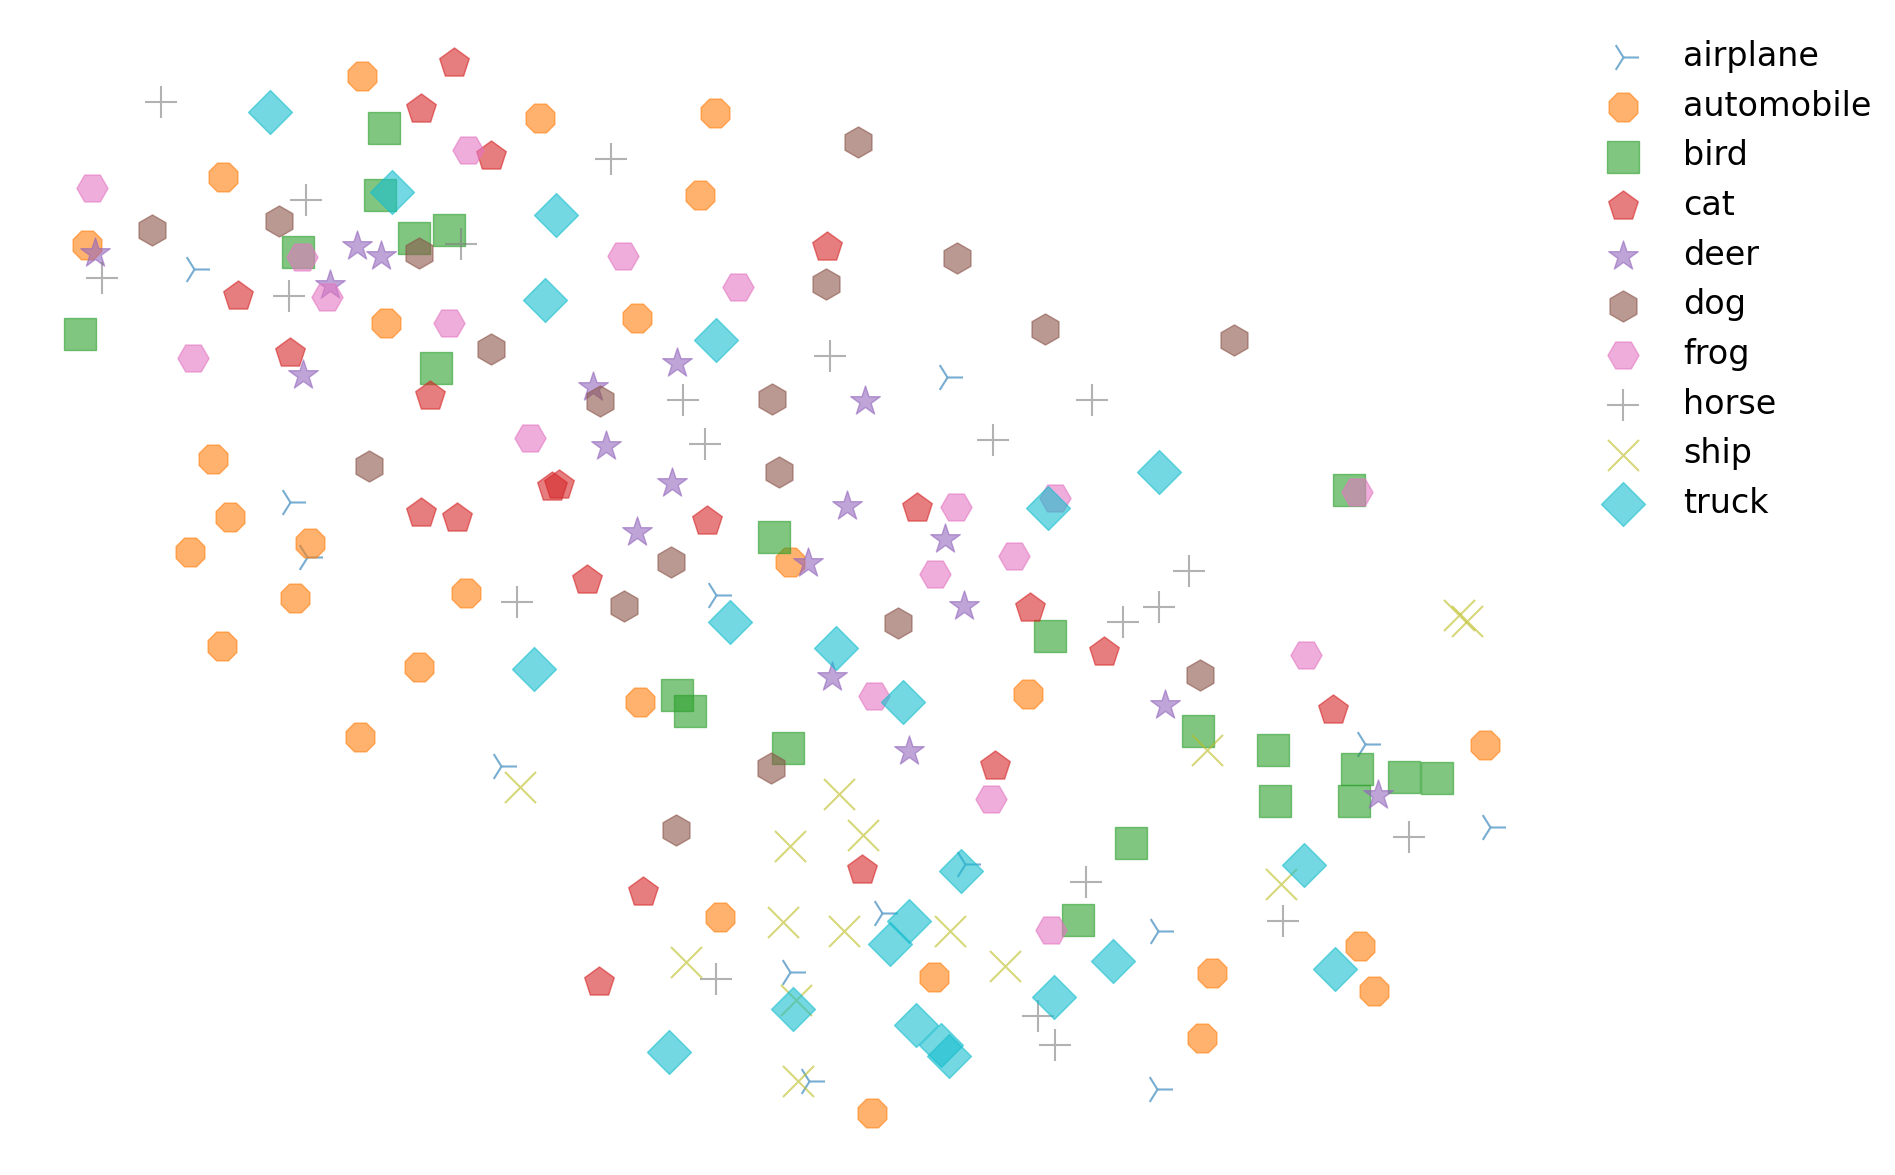

In [ ]:
# t-SNEのためにデータを整形
x = []
y = []
num_samples = 200
for i in range(num_samples):
  img, label = cifer10_check_dataset[i]

  # 画像を平坦化 ([32,32,3] -> [3027]に変換)
  img_flatten = np.asarray(img).flatten()
  x.append(img_flatten)
  y.append(label)

# 全データをNumpy配列に統合
x = np.stack(x)
y = np.array(y)

# t-SNEを適用(次元削減)
t_sne = TSNE(n_components=2, random_state=0)
x_reduced = t_sne.fit_transform(x)

# 各ラベルの色とマーカーを設定
cmap = plt.get_cmap("tab10")
markers = ['4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D']

# データをプロット
plt.figure(figsize=(20,15))
for i, cls in enumerate(cifer10_check_dataset.classes):
  plt.scatter(x_reduced[y==i,0],
              x_reduced[y==i,1],
              c=[cmap(i/len(cifer10_check_dataset.classes))],
              marker=markers[i], s=500, alpha=0.6, label=cls)
plt.axis('off')
plt.legend(bbox_to_anchor=(1,1), fontsize=24, framealpha=0)
plt.show()

###データセットを分割するための2つの排反なインデックス集合を生成する関数

In [ ]:
'''
dataset    : 分割対象のデータセット
ratio      : 1つ目のセットに含めるデータ量の割合
random_seed: 分割結果を不変にするためのシード
'''
# 要はインデックスをランダムに混ぜて2つの集合にわける
def generate_subset(dataset: Dataset, ratio: float,
                    random_seed: int=0):
    # サブセットの大きさを計算
    size = int(len(dataset) * ratio)

    indices = list(range(len(dataset)))

    # 二つのセットに分ける前にシャッフル
    random.seed(random_seed)
    random.shuffle(indices)

    # セット1とセット2のサンプルのインデックスに分割
    indices1, indices2 = indices[:size], indices[size:]

    return indices1, indices2

###学習、検証およびテストセットの生成と各セットの大きさの確認

In [ ]:
# 学習、テストセットの用意
train_dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='data', train=False, download=True)

# 学習セットのうち、検証セットに使う割合
val_ratio = 0.2

# Subsetの生成
val_set, train_set = generate_subset(train_dataset, val_ratio)

print(f'学習セットのサンプル数　: {len(train_set)}')
print(f'検証セットのサンプル数　: {len(val_set)}')
print(f'テストセットのサンプル数: {len(test_dataset)}')

Files already downloaded and verified
Files already downloaded and verified
学習セットのサンプル数　: 40000
検証セットのサンプル数　: 10000
テストセットのサンプル数: 10000


###画像整形関数

In [ ]:
'''
img         : 整形対象の画像
channel_mean: 各次元のデータセット全体の平均, [入力次元]
channel_std : 各次元のデータセット全体の標準偏差, [入力次元]
'''
def transform(img: Image.Image,
              channel_mean: np.ndarray=None,
              channel_std: np.ndarray=None):
    # PILからNumPy配列に変換
    img = np.asarray(img, dtype='float32')

    # [32, 32, 3]の画像を3072次元のベクトルに平坦化
    x = img.flatten()

    # 各次元をデータセット全体の平均と標準偏差で正規化(標準化)
    if channel_mean is not None and channel_std is not None:
        x = (x - channel_mean) / channel_std

    return x

###ラベル整形関数

In [ ]:
'''
label      : 物体クラスラベル
num_classes: データセットの物体クラス数
'''
def target_transform(label: int, num_classes: int=10):
    # 数字 -> One-hotに変換
    y = np.identity(num_classes)[label]
    return y

###各次元のデータセット全体の平均と標準偏差を計算する関数

In [ ]:
'''
dataset: 平均と標準偏差を計算する対象のPyTorchのデータセット
'''
def get_dataset_statistics(dataset: Dataset):
    data = []
    for i in range(len(dataset)):
        # 3072次元のベクトルを取得
        img_flat = dataset[i][0]
        data.append(img_flat)

    # 第0軸を追加して第0軸でデータを連結
    data = np.stack(data)

    # データ全体の平均と標準偏差を計算
    channel_mean = np.mean(data, axis=0)
    channel_std = np.std(data, axis=0)

    return channel_mean, channel_std

### データ整形処理の確認

In [ ]:
# # CIFAR10を準備(ダウンロード)
# # 標準化する
# cifer10_temp_dataset = torchvision.datasets.CIFAR10(root='data',
#                                                     train=True,
#                                                     download=True,
#                                                     transform=T.ToTensor(),
#                                                     )

# # 各次元のデータセット全体の平均と標準偏差を計算
# channel_mean, channel_std = get_dataset_statistics(cifer10_temp_dataset)

# print('channel_mean.shape', channel_mean.shape)
# print('channel_std.shape', channel_std.shape)

# # 正規化を含めた画像整形関数の用意
# img_transform = lambda x: transform(x, channel_mean.flatten(), channel_std.flatten())

# # 整形関数を渡して標準化データセットクラスインスタンスを生成
# cifer10_train_std_dataset = torchvision.datasets.CIFAR10(root='data',
#                                                          train=True,
#                                                          download=True,
#                                                          transform=img_transform,
#                                                          target_transform=target_transform)

# # データのサンプルと表示
# img, label = cifer10_train_std_dataset[0]
# print(f'画像 {img.shape}　: {img}')
# print(f'ラベル {label.shape} : {label}')

### 学習に必要なハイパーパラメータ

In [ ]:
class Config:
    '''
    ハイパーパラメータとオプションの設定
    '''
    def __init__(self):
        self.val_ratio = 0.2       # 検証に使う学習セット内のデータの割合
        self.patch_size = 4        # パッチサイズ
        self.dim_hidden = 512      # 隠れ層の次元
        self.num_heads = 8         # マルチヘッドアテンションのヘッド数
        self.dim_feedforward = 512 # Transformerエンコーダ層内のFNNにおける隠れ層の特徴量次元
        self.num_layers = 6        # Transformerエンコーダの層数
        self.num_epochs = 30       # 学習エポック数
        self.lr = 1e-2             # 学習率
        self.moving_avg = 20       # 移動平均で計算する損失と正確度の値の数
        self.batch_size = 32       # バッチサイズ
        self.num_workers = 2       # データローダに使うCPUプロセスの数
        self.device = 'cuda'       # 学習に使うデバイス
        self.num_samples = 200     # t-SNEでプロットするサンプル数

###モデル出力の確認

In [ ]:
# # ハイパーパラメータ
# config = Config()

# # Vision Transformerモデルの生成
# model = VisionTransformer(num_classes=len(train_dataset.classes),
#                           img_size=32,
#                           patch_size=config.patch_size,
#                           dim_hidden=config.dim_hidden,
#                           num_heads=config.num_heads,
#                           dim_feedforward=config.dim_feedforward,
#                           num_layers=config.num_layers,
#                           )

# # モデルを指定デバイスに転送(デフォルトはGPU)
# model.to(config.device)

# # モデルチェック

# print('概要')
# print(model)

# print('詳細')
# from torchsummary import summary
# print(summary(model, (3, 32, 32)))


## t-SNEによる2次元プロット

In [ ]:
'''
t-SNEのプロット関数
data_loader: プロット対象のデータを読み込むデータローダ
model      : 特徴量抽出に使うモデル
num_samples: t-SNEでプロットするサンプル数
'''
def plot_t_sne(data_loader: Dataset, model: nn.Module,
               num_samples: int):
    model.eval()

    # t-SNEのためにデータを整形
    x = []
    y = []
    for imgs, labels in data_loader:
        with torch.no_grad():
            imgs = imgs.to(model.get_device())

            # 特徴量の抽出
            embeddings = model(imgs, return_embed=True)

            x.append(embeddings.to('cpu'))
            y.append(labels.clone())

    x = torch.cat(x)
    y = torch.cat(y)

    # NumPy配列に変換
    x = x.numpy()
    y = y.numpy()

    # 指定サンプル数だけ抽出
    x = x[:num_samples]
    y = y[:num_samples]

    # t-SNEを適用
    t_sne = TSNE(n_components=2, random_state=0)
    x_reduced = t_sne.fit_transform(x)

    # 各ラベルの色とマーカーを設定
    cmap = plt.get_cmap("tab10")
    markers = ['4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D']

    # データをプロット
    plt.figure(figsize=(20, 15))
    for i, cls in enumerate(data_loader.dataset.classes):
        plt.scatter(x_reduced[y == i, 0], x_reduced[y == i, 1],
                    c=[cmap(i / len(data_loader.dataset.classes))],
                    marker=markers[i], s=500, alpha=0.6, label=cls)
    plt.axis('off')
    plt.legend(bbox_to_anchor=(1, 1), fontsize=24, framealpha=0)
    plt.show()

## 学習と評価

In [ ]:
from typing import Callable

import torch
from torch import nn
from torch.utils.data import Dataset


'''
data_loader: 評価に使うデータを読み込むデータローダ
model      : 評価対象のモデル
loss_func  : 目的関数
'''
def evaluate(data_loader: Dataset, model: nn.Module,
             loss_func: Callable):
    model.eval()

    losses = []
    preds = []
    for x, y in data_loader:
        with torch.no_grad():
            x = x.to(model.get_device())
            y = y.to(model.get_device())

            y_pred = model(x)

            losses.append(loss_func(y_pred, y, reduction='none'))
            preds.append(y_pred.argmax(dim=1) == y)

    loss = torch.cat(losses).mean()
    accuracy = torch.cat(preds).float().mean()

    return loss, accuracy

In [ ]:
def train_eval():
    config = Config()

    # 入力データ正規化のために学習セットのデータを使って
    # 各チャネルの平均と標準偏差を計算
    dataset = torchvision.datasets.CIFAR10(
        root='data', train=True, download=True,
        transform=T.ToTensor())
    channel_mean, channel_std = get_dataset_statistics(dataset)

    # 画像の整形を行うクラスのインスタンスを用意
    transforms = T.Compose((
        T.ToTensor(),
        T.Normalize(mean=channel_mean, std=channel_std),
    ))

    # 学習、評価セットの用意
    train_dataset = torchvision.datasets.CIFAR10(
        root='data', train=True, download=True,
        transform=transforms)
    test_dataset = torchvision.datasets.CIFAR10(
        root='data', train=False, download=True,
        transform=transforms)

    # 学習・検証セットへ分割するためのインデックス集合の生成
    val_set, train_set = generate_subset(
        train_dataset, config.val_ratio)

    print(f'学習セットのサンプル数　: {len(train_set)}')
    print(f'検証セットのサンプル数　: {len(val_set)}')
    print(f'テストセットのサンプル数: {len(test_dataset)}')

    # インデックス集合から無作為にインデックスをサンプルするサンプラー
    train_sampler = SubsetRandomSampler(train_set)

    # DataLoaderを生成
    train_loader = DataLoader(
        train_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers, sampler=train_sampler)
    val_loader = DataLoader(
        train_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers, sampler=val_set)
    test_loader = DataLoader(
        test_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers)

    # 目的関数の生成
    loss_func = F.cross_entropy

    # 検証セットの結果による最良モデルの保存用変数
    val_loss_best = float('inf')
    model_best = None

    # Vision Transformerモデルの生成
    model = VisionTransformer(num_classes=len(train_dataset.classes),
                            img_size=32,
                            patch_size=config.patch_size,
                            dim_hidden=config.dim_hidden,
                            num_heads=config.num_heads,
                            dim_feedforward=config.dim_feedforward,
                            num_layers=config.num_layers,
                            )

    # モデルを指定デバイスに転送(デフォルトはGPU)
    model.to(config.device)

    # 最適化器の生成
    optimizer = optim.SGD(model.parameters(), lr=config.lr)
    # optimizer = optim.Adam(model.parameters(), lr=config.lr)

    for epoch in range(config.num_epochs):
        model.train()

        with tqdm(train_loader) as pbar:
            pbar.set_description(f'[エポック {epoch + 1}]')

            # 移動平均計算用
            losses = deque()
            accs = deque()
            for x, y in pbar:
                # データをモデルと同じデバイスに転送
                x = x.to(model.get_device())
                y = y.to(model.get_device())

                # パラメータの勾配をリセット
                optimizer.zero_grad()

                # 順伝播
                y_pred = model(x)

                # 学習データに対する損失と正確度を計算
                loss = loss_func(y_pred, y)
                accuracy = (y_pred.argmax(dim=1) == y).float().mean()

                # 誤差逆伝播
                loss.backward()

                # パラメータの更新
                optimizer.step()

                # 移動平均を計算して表示
                losses.append(loss.item())
                accs.append(accuracy.item())
                if len(losses) > config.moving_avg:
                    losses.popleft()
                    accs.popleft()
                pbar.set_postfix({
                    'loss': torch.Tensor(losses).mean().item(),
                    'accuracy': torch.Tensor(accs).mean().item()})

        # 検証セットを使って精度評価
        val_loss, val_accuracy = evaluate(
            val_loader, model, loss_func)
        print(f'検証　: loss = {val_loss:.3f}, '
                f'accuracy = {val_accuracy:.3f}')

        # より良い検証結果が得られた場合、モデルを記録
        if val_loss < val_loss_best:
            val_loss_best = val_loss
            model_best = model.copy()

    # テスト
    test_loss, test_accuracy = evaluate(
        test_loader, model_best, loss_func)
    print(f'テスト: loss = {test_loss:.3f}, '
          f'accuracy = {test_accuracy:.3f}')

    # t-SNEを使って特徴量の分布をプロット
    plot_t_sne(test_loader, model_best, config.num_samples)


## 学習と評価を開始する

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
学習セットのサンプル数　: 40000
検証セットのサンプル数　: 10000
テストセットのサンプル数: 10000


[エポック 1]: 100%|██████████| 1250/1250 [00:57<00:00, 21.86it/s, loss=1.79, accuracy=0.325]


検証　: loss = 1.774, accuracy = 0.343


[エポック 2]: 100%|██████████| 1250/1250 [00:57<00:00, 21.57it/s, loss=1.59, accuracy=0.428]


検証　: loss = 1.539, accuracy = 0.440


[エポック 3]: 100%|██████████| 1250/1250 [00:58<00:00, 21.29it/s, loss=1.48, accuracy=0.466]


検証　: loss = 1.450, accuracy = 0.481


[エポック 4]: 100%|██████████| 1250/1250 [00:58<00:00, 21.22it/s, loss=1.38, accuracy=0.498]


検証　: loss = 1.371, accuracy = 0.495


[エポック 5]: 100%|██████████| 1250/1250 [00:59<00:00, 20.90it/s, loss=1.31, accuracy=0.527]


検証　: loss = 1.231, accuracy = 0.561


[エポック 6]: 100%|██████████| 1250/1250 [01:00<00:00, 20.80it/s, loss=1.2, accuracy=0.531]


検証　: loss = 1.221, accuracy = 0.559


[エポック 7]: 100%|██████████| 1250/1250 [00:59<00:00, 20.92it/s, loss=1.09, accuracy=0.605]


検証　: loss = 1.196, accuracy = 0.570


[エポック 8]: 100%|██████████| 1250/1250 [00:59<00:00, 20.99it/s, loss=1.01, accuracy=0.619]


検証　: loss = 1.205, accuracy = 0.563


[エポック 9]: 100%|██████████| 1250/1250 [00:59<00:00, 20.87it/s, loss=1.02, accuracy=0.623]


検証　: loss = 1.135, accuracy = 0.592


[エポック 10]: 100%|██████████| 1250/1250 [00:59<00:00, 20.93it/s, loss=0.952, accuracy=0.641]


検証　: loss = 1.146, accuracy = 0.588


[エポック 11]: 100%|██████████| 1250/1250 [00:59<00:00, 20.93it/s, loss=0.962, accuracy=0.644]


検証　: loss = 1.131, accuracy = 0.605


[エポック 12]: 100%|██████████| 1250/1250 [00:59<00:00, 20.85it/s, loss=0.959, accuracy=0.658]


検証　: loss = 1.061, accuracy = 0.627


[エポック 13]: 100%|██████████| 1250/1250 [00:59<00:00, 20.94it/s, loss=0.913, accuracy=0.67]


検証　: loss = 1.060, accuracy = 0.626


[エポック 14]: 100%|██████████| 1250/1250 [00:59<00:00, 20.92it/s, loss=0.798, accuracy=0.711]


検証　: loss = 1.063, accuracy = 0.636


[エポック 15]: 100%|██████████| 1250/1250 [01:00<00:00, 20.82it/s, loss=0.78, accuracy=0.716]


検証　: loss = 1.068, accuracy = 0.637


[エポック 16]: 100%|██████████| 1250/1250 [00:59<00:00, 20.90it/s, loss=0.652, accuracy=0.769]


検証　: loss = 1.135, accuracy = 0.630


[エポック 17]: 100%|██████████| 1250/1250 [00:59<00:00, 20.93it/s, loss=0.616, accuracy=0.798]


検証　: loss = 1.153, accuracy = 0.632


[エポック 18]: 100%|██████████| 1250/1250 [00:59<00:00, 20.86it/s, loss=0.61, accuracy=0.788]


検証　: loss = 1.181, accuracy = 0.630


[エポック 19]: 100%|██████████| 1250/1250 [00:59<00:00, 20.97it/s, loss=0.541, accuracy=0.792]


検証　: loss = 1.170, accuracy = 0.646


[エポック 20]: 100%|██████████| 1250/1250 [00:59<00:00, 20.94it/s, loss=0.525, accuracy=0.806]


検証　: loss = 1.231, accuracy = 0.639


[エポック 21]: 100%|██████████| 1250/1250 [00:59<00:00, 20.84it/s, loss=0.35, accuracy=0.877]


検証　: loss = 1.363, accuracy = 0.625


[エポック 22]: 100%|██████████| 1250/1250 [00:59<00:00, 20.94it/s, loss=0.36, accuracy=0.872]


検証　: loss = 1.456, accuracy = 0.625


[エポック 23]: 100%|██████████| 1250/1250 [00:59<00:00, 20.84it/s, loss=0.278, accuracy=0.902]


検証　: loss = 1.495, accuracy = 0.633


[エポック 24]: 100%|██████████| 1250/1250 [00:59<00:00, 20.92it/s, loss=0.241, accuracy=0.903]


検証　: loss = 1.578, accuracy = 0.633


[エポック 25]: 100%|██████████| 1250/1250 [00:59<00:00, 20.95it/s, loss=0.141, accuracy=0.952]


検証　: loss = 1.697, accuracy = 0.636


[エポック 26]: 100%|██████████| 1250/1250 [00:59<00:00, 20.94it/s, loss=0.15, accuracy=0.948]


検証　: loss = 1.785, accuracy = 0.638


[エポック 27]: 100%|██████████| 1250/1250 [00:59<00:00, 20.87it/s, loss=0.0364, accuracy=0.992]


検証　: loss = 1.848, accuracy = 0.651


[エポック 28]: 100%|██████████| 1250/1250 [00:59<00:00, 20.98it/s, loss=0.0114, accuracy=1]


検証　: loss = 1.903, accuracy = 0.657


[エポック 29]: 100%|██████████| 1250/1250 [00:59<00:00, 20.84it/s, loss=0.00475, accuracy=1]


検証　: loss = 1.953, accuracy = 0.659


[エポック 30]: 100%|██████████| 1250/1250 [00:59<00:00, 20.91it/s, loss=0.00306, accuracy=1]


検証　: loss = 2.008, accuracy = 0.661
テスト: loss = 1.069, accuracy = 0.623


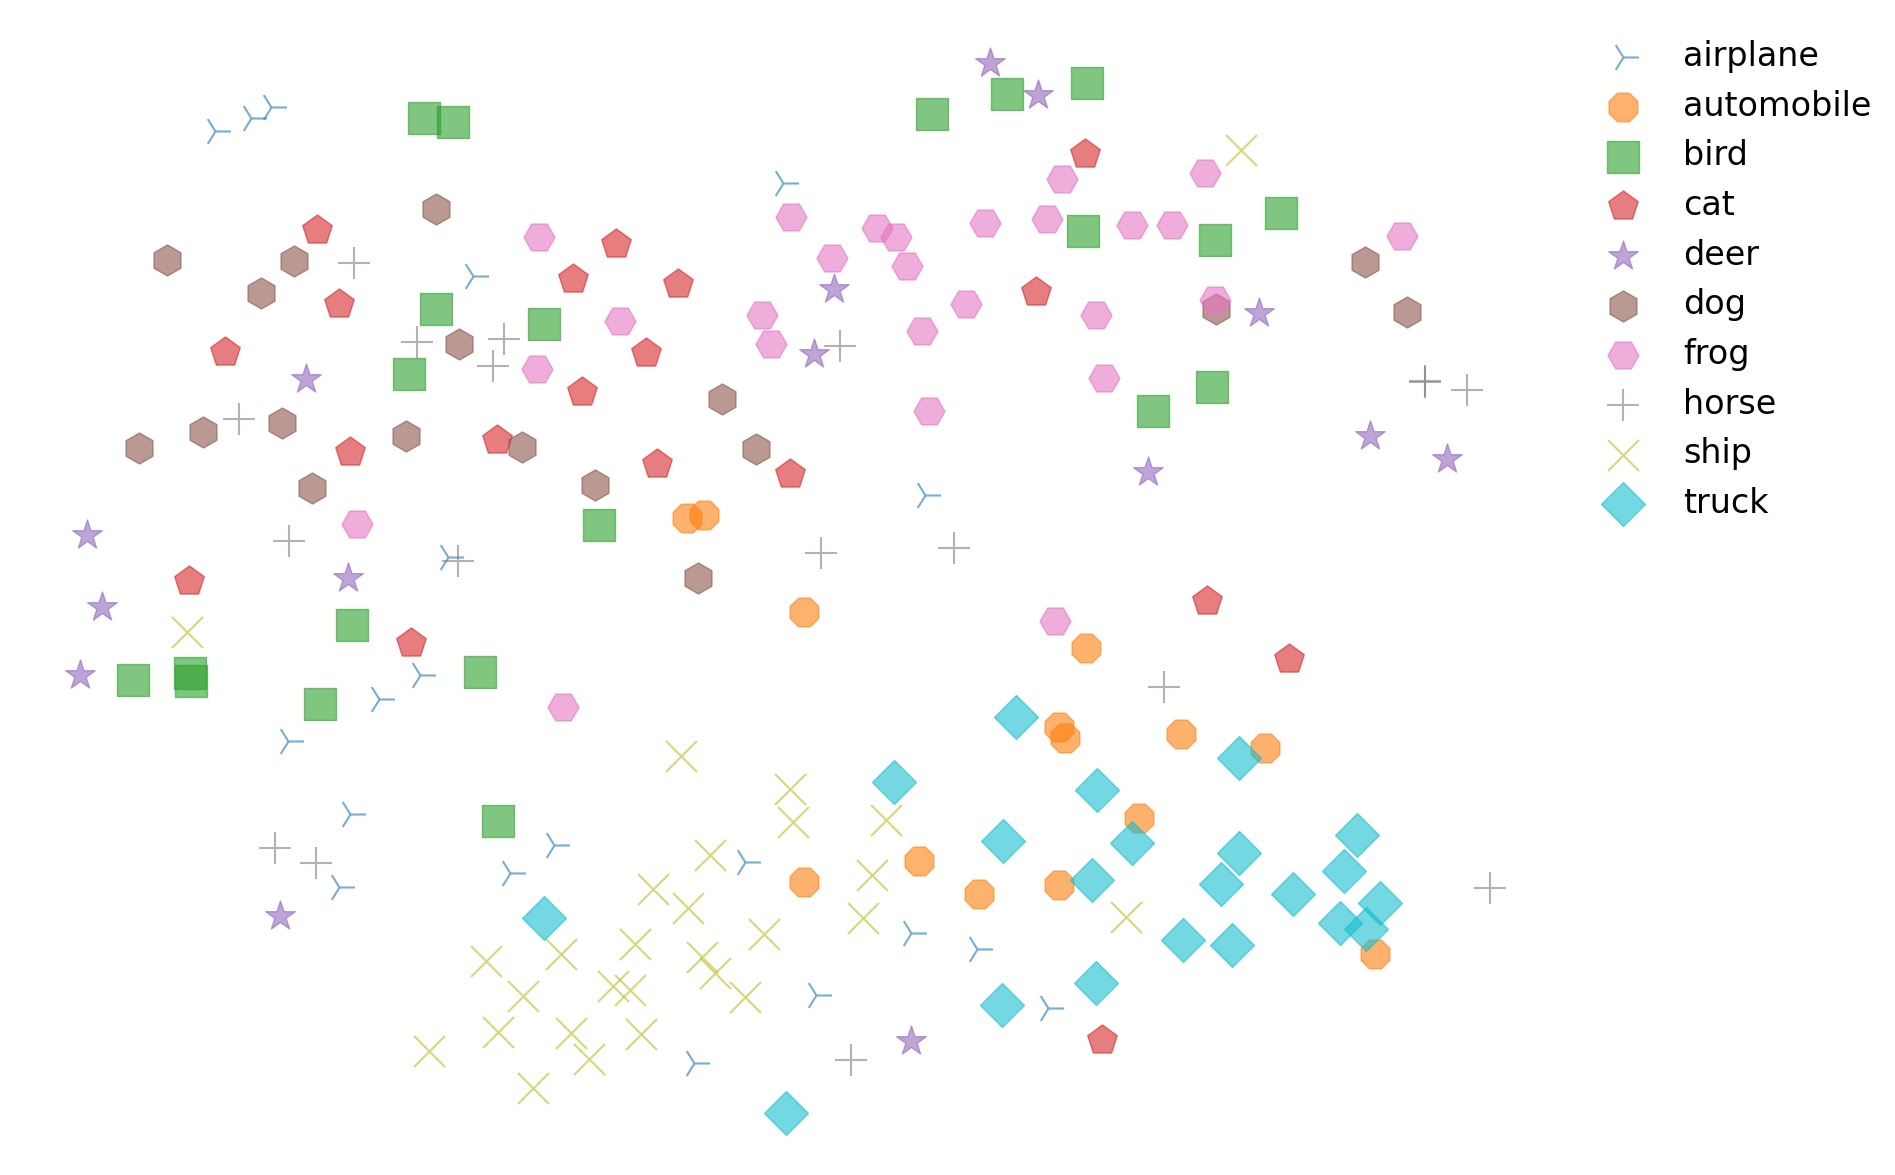

In [ ]:
train_eval()